In [1]:
import torch
from torch import nn
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# if torch.cuda.is_available(): 
#     dev = "cuda:0" 
# else: 
#     dev = "cpu" 
# device = torch.device(dev)

# Generate data

In [3]:
def func(x):
    return 8000 * (x + 20 * np.sin(x))

In [4]:
x = np.linspace(-20, 20, 4000, dtype=np.float32)
y = func(x)

training_data = pd.DataFrame(zip(x, y))
training_data

,0,1
0,-20.000000,-306071.21875
1,-19.989998,-305330.87500
2,-19.979996,-304575.93750
3,-19.969992,-303806.37500
4,-19.959990,-303022.53125
...,...,...
3995,19.959990,303022.53125
3996,19.969992,303806.37500
3997,19.979996,304575.93750
3998,19.989998,305330.87500


In [5]:
x_raw = training_data.iloc[:, :].values
y_raw = training_data.iloc[:, -1:].values
training_data = training_data.values

In [6]:
sc_x = MinMaxScaler()
sc_y = MinMaxScaler()

x_scaled = sc_x.fit_transform(x_raw)
y_scaled = sc_y.fit_transform(y_raw)

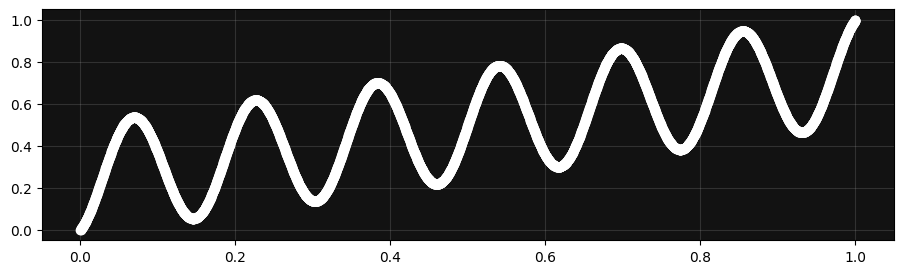

In [7]:
fig, ax = plt.subplots(figsize=(11, 3))
# ax.plot(x, y, '-w', label='$f_{true}=sin(x)$')
ax.plot(x_scaled[:,:-1], y_scaled, 'ow', label='$f_{true}$')
ax.set_facecolor('#121212')
# ax.legend(loc='upper left')
ax.grid(alpha=0.2)

# Prepare data

In [8]:
lookback = 6

In [9]:
x, y = [], []

for i in range(training_data.shape[0] - lookback):
    x.append(x_scaled[i:(i + lookback)])
    y.append(y_scaled[i + lookback])
    
x, y = np.array(x), np.array(y)

In [10]:
x[0], y[0]

(array([[0.        , 0.        ],
        [0.00025004, 0.00120941],
        [0.00050011, 0.00244269],
        [0.00075021, 0.00369984],
        [0.00100026, 0.00498036],
        [0.0012503 , 0.00628421]], dtype=float32),
 array([0.00761142], dtype=float32))

In [11]:
lim = int(len(x) * 0.2)

x_train, y_train = torch.tensor(x[:-lim]), torch.tensor(y[:-lim])
x_test, y_test = torch.tensor(x[-lim:]), torch.tensor(y[-lim:])
x, y = torch.tensor(x), torch.tensor(y)

In [12]:
x_train.shape, y_train.shape

(torch.Size([3196, 6, 2]), torch.Size([3196, 1]))

In [13]:
x_train[0]

tensor([[0.0000, 0.0000],
        [0.0003, 0.0012],
        [0.0005, 0.0024],
        [0.0008, 0.0037],
        [0.0010, 0.0050],
        [0.0013, 0.0063]])

In [14]:
y_train[0]

tensor([0.0076])

# LSTM Model

In [15]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Training

In [16]:
model = LSTM(input_size=2, hidden_size=40, num_layers=1, output_size=1)

In [17]:
epochs = 2000
lr = 0.001

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    y_pred = model(x_train)

    optimizer.zero_grad()
    loss = loss_function(y_pred, y_train)

    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        with torch.no_grad():
            print("{}:\tloss: {:.10f}".format(epoch, loss.item()))

0:	loss: 0.2179691494
100:	loss: 0.0052690292
200:	loss: 0.0003521453
300:	loss: 0.0000781910
400:	loss: 0.0000628693
500:	loss: 0.0000613619
600:	loss: 0.0000599094
700:	loss: 0.0000584595
800:	loss: 0.0000570216
900:	loss: 0.0000556024
1000:	loss: 0.0000542075
1100:	loss: 0.0000528424
1200:	loss: 0.0000515123
1300:	loss: 0.0000502230
1400:	loss: 0.0000489803
1500:	loss: 0.0000477906
1600:	loss: 0.0000466605
1700:	loss: 0.0000455962
1800:	loss: 0.0000446032
1900:	loss: 0.0000436846


# Results

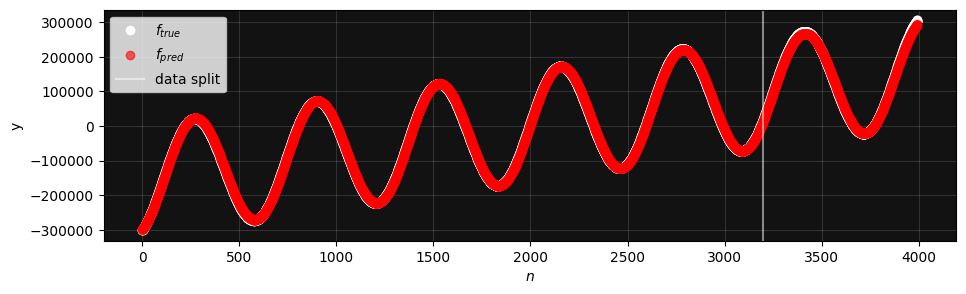

In [18]:
fig, ax = plt.subplots(figsize=(11, 3))

ax.plot(sc_y.inverse_transform(y.reshape(-1, 1)), 'ow', label='$f_{true}$')
ax.plot(sc_y.inverse_transform(model(x).data.numpy().squeeze().reshape(-1, 1)), 'or', alpha=0.6, label='$f_{pred}$')
ax.axvline(len(y) - lim, c='white', alpha=0.5, label='data split')
ax.set_xlabel('$n$')
ax.set_ylabel('y')
ax.set_facecolor('#121212')
ax.legend(loc='upper left')
ax.grid(alpha=0.2)

plt.show()

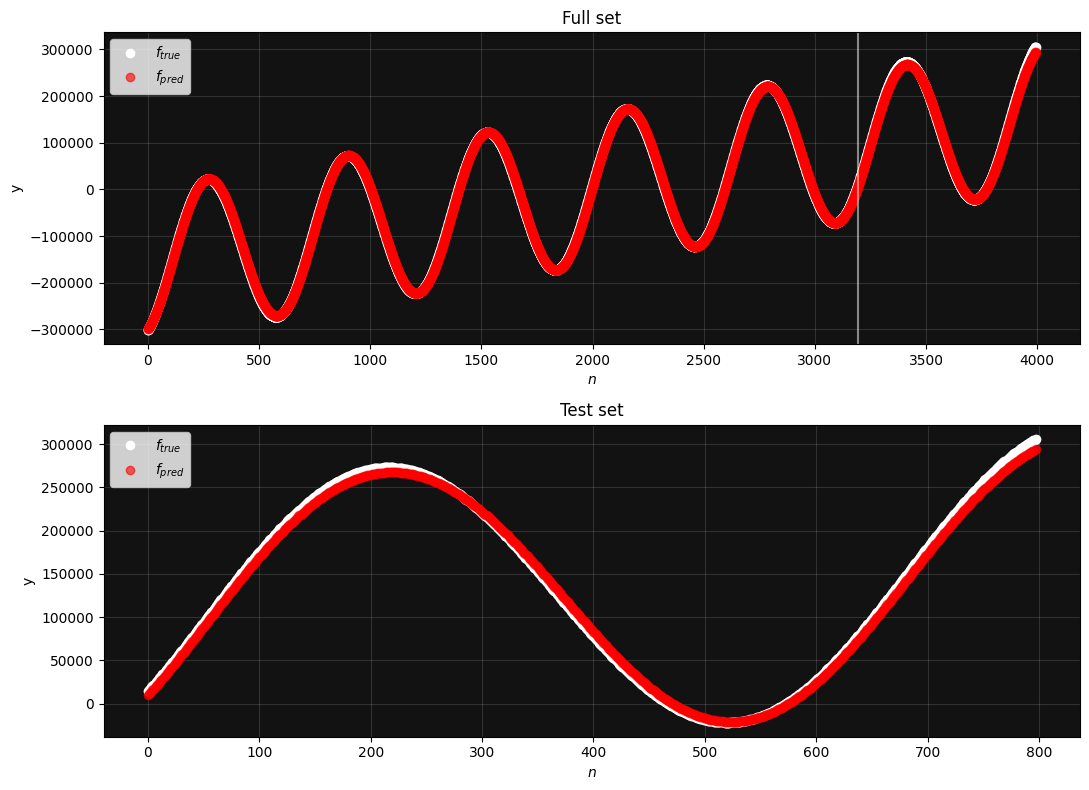

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(11, 8))

axes[0].plot(sc_y.inverse_transform(y), 'ow', label='$f_{true}$')
axes[0].plot(sc_y.inverse_transform(model(x).data.numpy()), 'or', alpha=0.6, label='$f_{pred}$')
axes[0].set_xlabel('$n$')
axes[0].set_ylabel('y')
axes[0].set_facecolor('#121212')
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.2)
axes[0].set_title('Full set')
axes[0].axvline(len(y.data.numpy()) - lim, c='white', alpha=0.5, label='data_split')

axes[1].plot(sc_y.inverse_transform(y_test), 'ow', label='$f_{true}$')
axes[1].plot(sc_y.inverse_transform(model(x_test).data.numpy()), 'or', alpha=0.6, label='$f_{pred}$')
axes[1].set_xlabel('$n$')
axes[1].set_ylabel('y')
axes[1].set_facecolor('#121212')
axes[1].legend(loc='upper left')
axes[1].grid(alpha=0.2)
axes[1].set_title('Test set')

plt.tight_layout()
plt.show()